# Transfer learning _ResNet-50

# 1.Importing libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd  
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 2.Loading data/ Preprocessing

In [2]:
data_dir = "dermnet/train"#directory of the  train data
test_dir = "dermnet/test"#directory of the  test data

In [3]:
height,width=180,180#Size of the image
batch_size=32
train_dataset =tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height,width),# resize images after they are read from folder
  batch_size=batch_size)#Size of the batches of data to load at a time

Found 7672 files belonging to 5 classes.
Using 6138 files for training.


In [4]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height,width),
  batch_size=batch_size)

Found 7672 files belonging to 5 classes.
Using 1534 files for validation.


In [5]:
#testing data preprocessing
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,#directory of the  test data
    shuffle = True,
    seed=123,
    image_size =(height,width),
    batch_size =batch_size  
)

Found 1163 files belonging to 5 classes.


In [6]:
class_names=train_dataset.class_names
print(class_names)

['Acne and Rosacea Photos', 'Eczema Photos', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases']


# 3.Data Visualization/Plotting

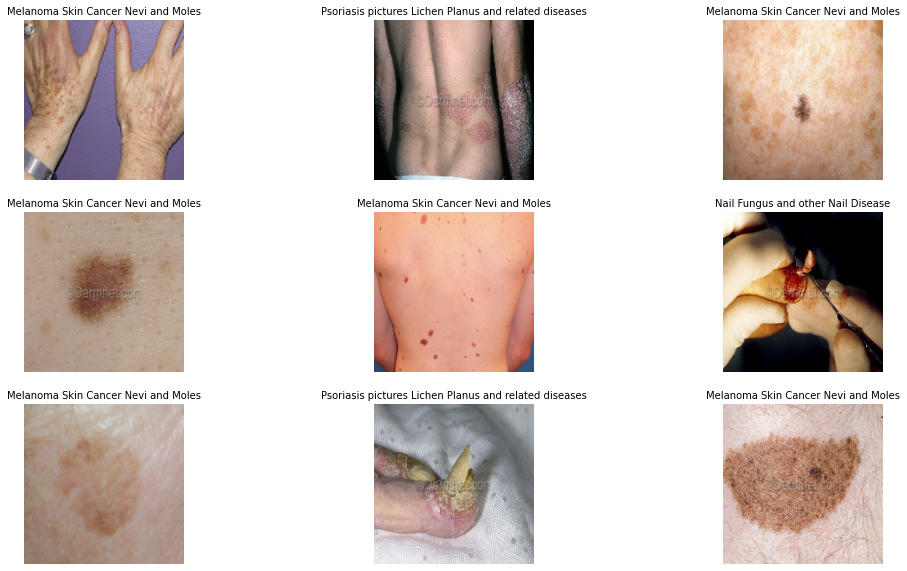

In [7]:
#using matplotlib to visualize the images in the dataset 
plt.figure(figsize = (10,10))#setting the size images in plot only
for images, labels in train_dataset.take(1):#looping through the dataset
   for i in range(9):
     ax = plt.subplot(3,3,i+1)
     plt.imshow(images[i].numpy().astype("uint8"))
     plt.title(class_names[labels[i]],fontsize = 10)
     plt.subplots_adjust(right =1.5)   
     plt.axis("off")

In [8]:
#adding file counts and disease names to pandas DF to check data distribution 
location = Path('dermnet/train')
array = []
for folders in location.glob("*"):
    row = {}#depicts a row
    row["disease"] = folders.name.replace("Photos", "")
    list = os.listdir(folders) #directory of the current folder 
    countFiles = len(list)#count number of files in folder 
    row["count"] =countFiles
    array.append(row)  
df=pd.DataFrame(array) 
print(df)

                                             disease  count
0                                  Acne and Rosacea    1403
1                                            Eczema    1557
2                Melanoma Skin Cancer Nevi and Moles   1356
3                 Nail Fungus and other Nail Disease   1301
4  Psoriasis pictures Lichen Planus and related d...   2055


<AxesSubplot:>

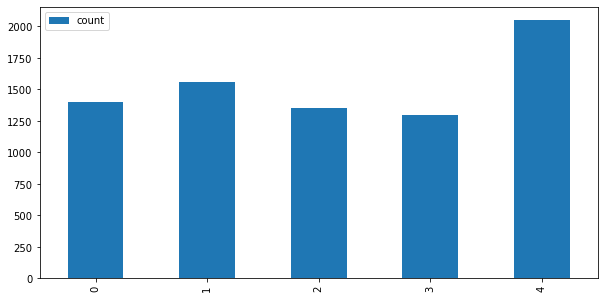

In [9]:
#plotting a graph to check data distribution amoung classes
fig, ax = plt.subplots(1, 1, figsize= (10, 5))
df.plot(kind='bar', ax=ax)

# 4.Loading resnet50 and adding layers

In [10]:
model= Sequential()#extra layers will be added one after the other
resnet_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),#input size of the image
                   pooling='avg',classes=5,
                   weights='imagenet')#using the imagenet weights 
for layer in resnet_model.layers:
        layer.trainable=False#freezing layers of the resnet model
     

In [11]:
#adding layers to pretrained model
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))#output layer

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

C:\Users\GEETH\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 5.Training the model

In [14]:
epochs=13
history=model.fit(train_dataset,validation_data=val_dataset,epochs=epochs)

Epoch 1/13
192/192 [==============================] - 133s 668ms/step - loss: 1.0921 - accuracy: 0.6121 - val_loss: 0.8307 - val_accuracy: 0.6558
Epoch 2/13
192/192 [==============================] - 50s 261ms/step - loss: 0.7163 - accuracy: 0.7297 - val_loss: 0.8132 - val_accuracy: 0.6767
Epoch 3/13
192/192 [==============================] - 37s 194ms/step - loss: 0.5615 - accuracy: 0.7851 - val_loss: 0.7672 - val_accuracy: 0.7073
Epoch 4/13
192/192 [==============================] - 37s 192ms/step - loss: 0.4482 - accuracy: 0.8394 - val_loss: 0.7559 - val_accuracy: 0.7197
Epoch 5/13
192/192 [==============================] - 37s 194ms/step - loss: 0.3576 - accuracy: 0.8703 - val_loss: 0.8026 - val_accuracy: 0.7177
Epoch 6/13
192/192 [==============================] - 38s 194ms/step - loss: 0.2787 - accuracy: 0.8988 - val_loss: 0.7794 - val_accuracy: 0.7288
Epoch 7/13
192/192 [==============================] - 37s 194ms/step - loss: 0.2202 - accuracy: 0.9244 - val_loss: 0.8056 - val_a

# 6.Model Evaluation

Text(0.5, 1.0, 'Training and Validation Accuracy')

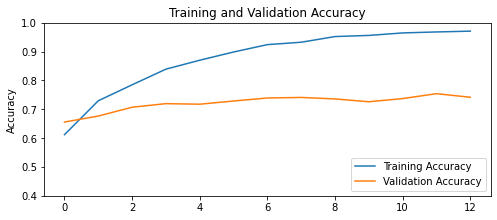

In [15]:
#plotting the learning curves training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(8, 7))
plt.subplot(2, 1, 1)
plt.axis(ymin=0.4,ymax=1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [16]:
#testing model accuracy with the testing set(unbiased)
score =model.evaluate(test_dataset)
print('Test accuracy:', score[1])

37/37 [==============================] - 14s 287ms/step - loss: 2.0264 - accuracy: 0.6156
Test accuracy: 0.6156491637229919


In [17]:
#predicting multiple images
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

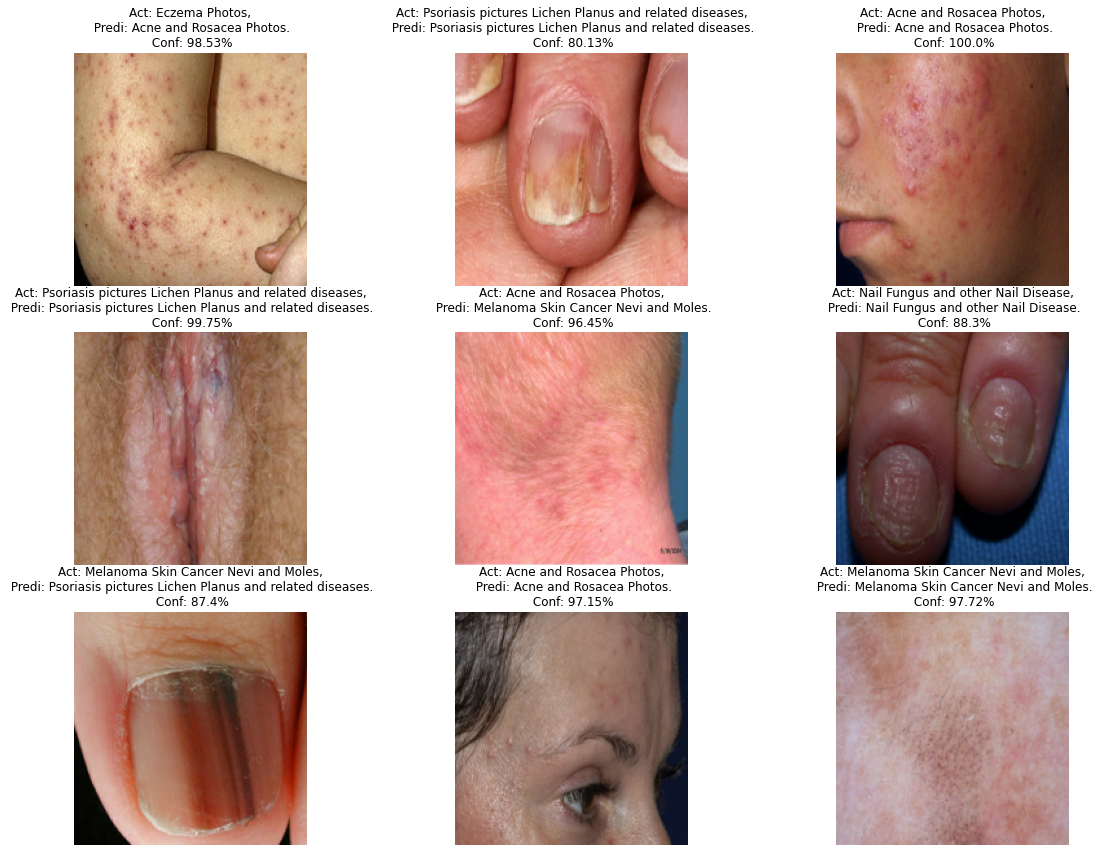

In [18]:
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_image(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.subplots_adjust(right =2,top=1.5)
        plt.title(f"Act: {actual_class},\n Predi: {predicted_class}.\n Conf: {confidence}%")
        plt.axis("off")

In [19]:
#Getting f-1 score,precision,recall using sklearn.metrics.classification_report
y_pred = []  
y_true = []  

for image_batch, label_batch in test_dataset:
   y_true.append(label_batch)
   predictions = model.predict(image_batch)#predict using model
   y_pred.append(np.argmax(predictions, axis = - 1))


true_classes= tf.concat([item for item in y_true], axis = 0)
predicted_classes= tf.concat([item for item in y_pred], axis = 0)


report = metrics.classification_report(true_classes , predicted_classes, target_names=class_names)
print(report)

#sklearn classification_report


                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.79      0.70      0.74       376
                                        Eczema Photos       0.22      0.08      0.12       120
                  Melanoma Skin Cancer Nevi and Moles       0.41      0.78      0.54       194
                   Nail Fungus and other Nail Disease       0.25      0.30      0.27        27
Psoriasis pictures Lichen Planus and related diseases       0.74      0.63      0.68       446

                                             accuracy                           0.62      1163
                                            macro avg       0.48      0.50      0.47      1163
                                         weighted avg       0.63      0.62      0.61      1163



# 7.Saving the model,creating tflite model

In [20]:
model.save("model.h5")

C:\Users\GEETH\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [21]:
saved_model_path = "model.h5"
model = tf.keras.models.load_model(saved_model_path)

In [22]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/skin_model.tflite"
TFLITE_QUANT_MODEL = "tflite_models/skin_quant_model.tflite"

In [23]:
run_model = tf.function(lambda x :model(x))

In [24]:
concrete_function = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

In [25]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_function])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

98180572

In [26]:
#quant model to reduce model size
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

25195872

In [27]:
#creating labels.txt file
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))